# CHAPTER 7.1

### Implementing a reusable image caption feature extractor

this notebook is prepared with the help of https://github.com/PacktPublishing/Tensorflow-2.0-Computer-Vision-Cookbook/tree/master/ch7 github repo. This is just a quick review about subject and notes for myself. If you want to reach original codes, you can check it.

The first step of creating an image captioning, deep learning-based solution is to transform the data into a format that can be used by certain networks. This means we must encode images as vectors, or tensors, and the text as embeddings, which are
vectorial representations of sentences.

We will use https://www.kaggle.com/adityajn105/flickr8k. dataset. In this dataset, we have 8091 images,and a txt file which describe each images about 5 times in different sentences. Here is an example for understanding : 


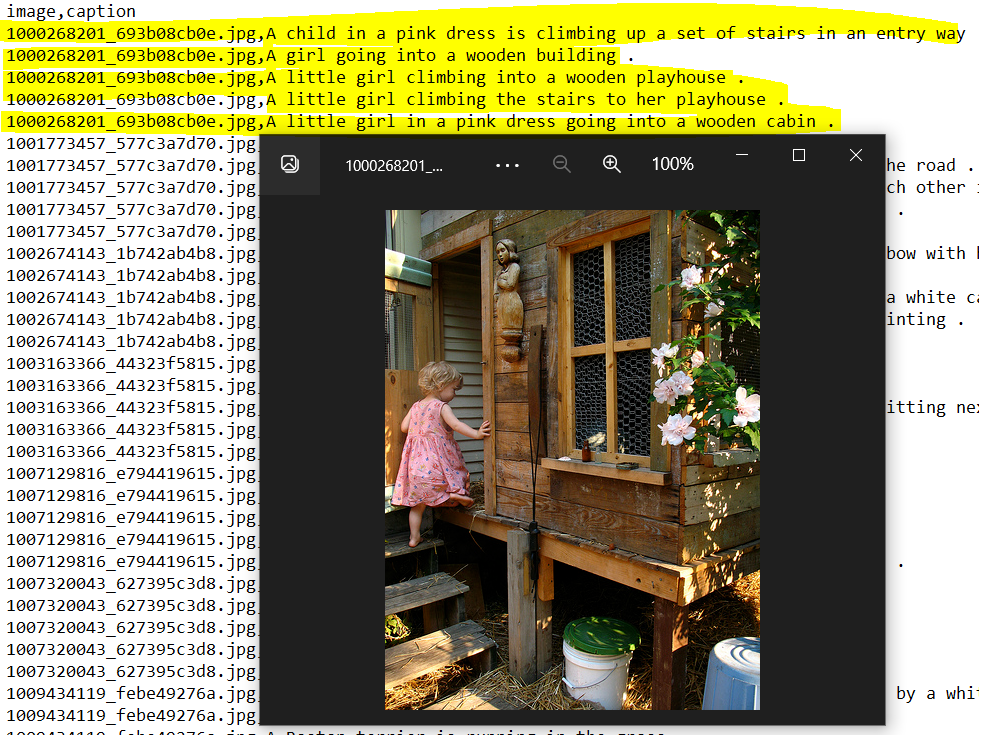

A quick summaru about what we will do is (from book Tensorflow-2.0-Computer-Vision-Cookbook):


There are many ways to frame an image captioning problem, but the most popular and effective way is to use each word to generate the next word in the caption. This way, we'll construct the sentence, word by word, passing each intermediate output as the input to the next cycle. 
we convert each image in our dataset into a numeric vector that summarizes the spatial information in each picture. Then, we pass the same feature vector along each input sequence when training the network. This way, the network will learn to associate all the words in a caption with the same image.

If we're not careful, we could get trapped in an endless loop of word generation. How can
we prevent this? By using a special token to signal the end of a sequence

In [1]:
import glob
import os
import pathlib
import pickle
from string import punctuation

import numpy as np
import tqdm
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.preprocessing.sequence import \
    pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

As always , I firstly try to run each code step by step and show what it does, then for all dataset I will use functions and for loop which can be found in original github repo of course.

In [2]:
caption_path='captions_example.txt'

In [3]:
with open(caption_path, 'r') as f:
    text = f.read()
    lines = text.split('\n')

In [4]:
text

'image,caption\n10815824_2997e03d76.jpg,A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .\n10815824_2997e03d76.jpg,A girl and her horse stand by a fire .\n10815824_2997e03d76.jpg,A girl holding a horse \'s lead behind a fire .\n10815824_2997e03d76.jpg,"A man , and girl and two horses are near a contained fire ."\n10815824_2997e03d76.jpg,Two people and two horses watching a fire .'

In [6]:
lines

['image,caption',
 '10815824_2997e03d76.jpg,A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .',
 '10815824_2997e03d76.jpg,A girl and her horse stand by a fire .',
 "10815824_2997e03d76.jpg,A girl holding a horse 's lead behind a fire .",
 '10815824_2997e03d76.jpg,"A man , and girl and two horses are near a contained fire ."',
 '10815824_2997e03d76.jpg,Two people and two horses watching a fire .']

In [7]:
type(lines)

list

In [8]:
len(lines)

6

In [9]:
line_1=lines[1]
print(line_1)

10815824_2997e03d76.jpg,A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .


In [11]:
#we need to seperate the image_file_name from caption
tokens = line_1.split(',', maxsplit=1)

In [12]:
tokens

['10815824_2997e03d76.jpg',
 'A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .']

In [13]:
image_id, image_caption = tokens
print('image name is {}'.format(image_id))
print('image_caption is {}'.format(image_caption))

image name is 10815824_2997e03d76.jpg
image_caption is A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .


In [14]:
 # Remove filename from image id
image_id = image_id.split('.')[0] 

In [15]:
mapping = {}
captions_per_image = mapping.get(image_id, [])

In [16]:
mapping

{}

In [19]:
captions_per_image

[]

In [20]:
len(captions_per_image)

0

In [21]:
captions_per_image.append(image_caption)

In [22]:
captions_per_image

['A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .']

In [23]:
mapping[image_id] = captions_per_image

In [24]:
captions_per_image

['A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .']

In [25]:
mapping

{'10815824_2997e03d76': ['A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .']}

As you can see, we collect image id and its captions in a dictionary. we need to apply this process for all images and captions. But again for an example, I will do it with an image then i will create for loop

In [26]:
with open(caption_path, 'r') as f:
    text = f.read()
    lines = text.split('\n')

mapping = {}
for line in lines:
    if '.jpg' not in line:
        continue
    tokens = line.split(',', maxsplit=1)

    if len(line) < 2:
        continue

    image_id, image_caption = tokens
    image_id = image_id.split('.')[0]  # Remove filename from image id

    captions_per_image = mapping.get(image_id, [])
    captions_per_image.append(image_caption)

    mapping[image_id] = captions_per_image

In [27]:
mapping

{'10815824_2997e03d76': ['A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .',
  'A girl and her horse stand by a fire .',
  "A girl holding a horse 's lead behind a fire .",
  '"A man , and girl and two horses are near a contained fire ."',
  'Two people and two horses watching a fire .']}

In [41]:
image_id='10815824_2997e03d76'

In [42]:
#we just need one caption for each image
captions.append(mapping[image_id][0])

In [43]:
captions

['A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .']

Now we need to apply some preprocess to make a clean sentence. Lets make an example before using it in a function. We will remove one letter words like 'a' and punctuations

In [122]:
cleaned_captions = []
caption_1 = captions[0].lower().split(' ')

In [123]:
caption_1

['a',
 'blonde',
 'horse',
 'and',
 'a',
 'blonde',
 'girl',
 'in',
 'a',
 'black',
 'sweatshirt',
 'are',
 'staring',
 'at',
 'a',
 'fire',
 'in',
 'a',
 'barrel',
 '.']

In [124]:
type(caption_1)

list

In [125]:
def remove_punctuation(word):
    translation = str.maketrans('', '',punctuation)
    return word.translate(translation)

caption_1 = map(remove_punctuation, caption_1)

In [126]:
type(caption_1)

map

### !! you can't use map object in filter, because of that we should change it to list then apply filter. There is a mistake in book !! 

In [127]:
caption_1=list(caption_1)

In [128]:
type(caption_1)

list

In [129]:
print(list(caption_1))

['a', 'blonde', 'horse', 'and', 'a', 'blonde', 'girl', 'in', 'a', 'black', 'sweatshirt', 'are', 'staring', 'at', 'a', 'fire', 'in', 'a', 'barrel', '']


In [130]:
#Check if all the characters in the text are letters
def is_valid_word(word):
    return len(word) > 1 and word.isalpha()

caption_1 = filter(is_valid_word, caption_1)

In [131]:
caption_list=list(caption_1)

In [132]:
type(caption_list)

list

In [133]:
caption_list

['blonde',
 'horse',
 'and',
 'blonde',
 'girl',
 'in',
 'black',
 'sweatshirt',
 'are',
 'staring',
 'at',
 'fire',
 'in',
 'barrel']

In [141]:

cleaned_caption = 'beginsequence ' + f'{" ".join(caption_list)} ' +' endsequence'
cleaned_captions.append(cleaned_caption)

In [142]:
cleaned_caption

'beginsequence blonde horse and blonde girl in black sweatshirt are staring at fire in barrel  endsequence'

Cleaned captions is one part of our dataset. We also need a feature extraction process. For this purpose , as ana example i will use a pretrained model which is VGG16

In [144]:
input = Input(shape=(224,224,3))
model=VGG16(input_tensor=input, weights='imagenet',include_top=False)

In [146]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [148]:
image_path=r'C:\Users\Zeki\Desktop\kisisel calismalar\github_notebooks\Captioning_Images\images_example\10815824_2997e03d76.jpg'
image = load_img(image_path,target_size=(224,224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

In [149]:
image

array([[[[ -17.939003 ,  -15.778999 ,    3.3199997],
         [ -15.939003 ,  -13.778999 ,    5.3199997],
         [ -19.939003 ,  -18.779    ,    2.3199997],
         ...,
         [  32.060997 ,   42.221    ,   81.32     ],
         [  34.060997 ,   41.221    ,   82.32     ],
         [  32.060997 ,   39.221    ,   80.32     ]],

        [[ -12.939003 ,  -10.778999 ,    8.32     ],
         [ -11.939003 ,   -9.778999 ,    9.32     ],
         [ -21.939003 ,  -19.779    ,   -0.6800003],
         ...,
         [  34.060997 ,   44.221    ,   83.32     ],
         [  35.060997 ,   42.221    ,   82.32     ],
         [  34.060997 ,   41.221    ,   81.32     ]],

        [[ -13.939003 ,  -11.778999 ,    7.3199997],
         [ -11.939003 ,   -9.778999 ,    9.32     ],
         [ -26.939003 ,  -23.779    ,   -7.6800003],
         ...,
         [  34.060997 ,   44.221    ,   83.32     ],
         [  34.060997 ,   41.221    ,   81.32     ],
         [  34.060997 ,   41.221    ,   81.32     ]],

In [151]:
image.shape

(1, 224, 224, 3)

In [152]:
feat_ext=model.predict(image)

In [154]:
feat_ext.shape

(1, 7, 7, 512)

if you check the model summary, the output of model has 7x7x512... this is why we got these dimension,not a classification result or one dimensional vector

In [155]:
feat_ext_1=feat_ext[0]

In [156]:
feat_ext_1.shape

(7, 7, 512)

We will create a map with image id, captions and features... So basicly we understand how we will reach each of these data. Now I will use the code blocks from reference repo and see all them together

In [158]:
#our main class to create datasets and feature extraction
class ImageCaptionFeatureExtractor(object):
    def __init__(self,
                 output_path='.',
                 start_token='beginsequence',
                 end_token='endsequence',
                 feature_extractor=None,
                 input_shape=(224, 224, 3)):
        self.input_shape = input_shape

        if feature_extractor is None:
            input = Input(shape=input_shape)
            self.feature_extractor = VGG16(input_tensor=input,
                                           weights='imagenet',
                                           include_top=False)
        else:
            self.feature_extractor = feature_extractor

        self.output_path = output_path
        self.start_token = start_token
        self.end_token = end_token
        self.tokenizer = Tokenizer()
        self.max_seq_length = None

    def extract_image_features(self, image_path):
        image = load_img(image_path,
                         target_size=self.input_shape[:2])
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)

        return self.feature_extractor.predict(image)[0]

    def _clean_captions(self, captions):
        def remove_punctuation(word):
            translation = str.maketrans('', '',
                                        punctuation)
            return word.translate(translation)

        def is_valid_word(word):
            return len(word) > 1 and word.isalpha()

        cleaned_captions = []
        for caption in captions:
            caption = caption.lower().split(' ')
            caption = map(remove_punctuation, caption)
            caption = filter(is_valid_word, caption)

            cleaned_caption = f'{self.start_token} ' \
                              f'{" ".join(caption)} ' \
                              f'{self.end_token}'
            cleaned_captions.append(cleaned_caption)

        return cleaned_captions

    def _get_max_seq_length(self, captions):
        max_sequence_length = -1

        for caption in captions:
            caption_length = len(caption.split(' '))
            max_sequence_length = max(max_sequence_length,
                                      caption_length)

        return max_sequence_length

    def extract_features(self, images_path, captions):
        assert len(images_path) == len(captions)

        captions = self._clean_captions(captions)
        self.max_seq_length = self._get_max_seq_length(captions)
        self.tokenizer.fit_on_texts(captions)

        data_mapping = {}
        print('\nExtracting features...')
        for i in tqdm(range(len(images_path))):
            image_path = images_path[i]
            caption = captions[i]

            feats = self.extract_image_features(image_path)

            image_id = image_path.split(os.path.sep)[-1]
            image_id = image_id.split('.')[0]

            data_mapping[image_id] = {
                'features': feats,
                'caption': caption
            }

        out_path = f'{self.output_path}/data_mapping.pickle'
        with open(out_path, 'wb') as f:
            pickle.dump(data_mapping, f, protocol=4)

        self._create_sequences(data_mapping)

    def _create_sequences(self, mapping):
        num_classes = len(self.tokenizer.word_index) + 1

        in_feats = []
        in_seqs = []
        out_seqs = []

        print('\nCreating sequences...')
        for _, data in tqdm(mapping.items()):
            feature = data['features']
            caption = data['caption']

            seq, = self.tokenizer.texts_to_sequences([caption])

            for i in range(1, len(seq)):
                input_seq = seq[:i]
                input_seq, = pad_sequences([input_seq],
                                           self.max_seq_length)

                # ONE HOT ENCODING
                out_seq = seq[i]
                out_seq = to_categorical([out_seq],
                                         num_classes)[0]

                in_feats.append(feature)
                in_seqs.append(input_seq)
                out_seqs.append(out_seq)

        file_paths = [
            f'{self.output_path}/input_features.pickle',
            f'{self.output_path}/input_sequences.pickle',
            f'{self.output_path}/output_sequences.pickle']
        sequences = [in_feats,
                     in_seqs,
                     out_seqs]

        for path, seq in zip(file_paths, sequences):
            with open(path, 'wb') as f:
                pickle.dump(np.array(seq), f, protocol=4)



In [160]:
#define our paths
BASE_PATH = (pathlib.Path.home() / '.keras' / 'datasets' /'flickr8k')
IMAGES_PATH = str(BASE_PATH / 'Images')
CAPTIONS_PATH = str(BASE_PATH / 'captions.txt')

In [161]:
extractor = ImageCaptionFeatureExtractor(output_path='.')

In [162]:
image_paths = list(glob.glob(f'{IMAGES_PATH}/*.jpg'))

In [163]:
len(image_paths)

8091

In [164]:
with open(CAPTIONS_PATH, 'r') as f:
    text = f.read()
    lines = text.split('\n')

mapping = {}
for line in lines:
    if '.jpg' not in line:
        continue
    tokens = line.split(',', maxsplit=1)

    if len(line) < 2:
        continue

    image_id, image_caption = tokens
    image_id = image_id.split('.')[0]  # Remove filename from image id

    captions_per_image = mapping.get(image_id, [])
    captions_per_image.append(image_caption)

    mapping[image_id] = captions_per_image

In [165]:
#all captions with their imagenames
mapping

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

In [168]:
#but we only take one caption for each image...
captions = []
for image_path in image_paths:
    image_id = image_path.split('\\')[-1].split('.')[0]

    captions.append(mapping[image_id][0])

In [169]:
captions

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A black dog and a spotted dog are fighting',
 'A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A man lays on a bench while his dog sits by him .',
 'A man in an orange hat starring at something .',
 'A child playing on a rope net .',
 'A black and white dog is running in a grassy garden surrounded by a white fence .',
 '"A dog shakes its head near the shore , a red ball next to it ."',
 'A boy smiles in front of a stony wall in a city .',
 'A black dog leaps over a log .',
 'A brown and white dog is running through the snow .',
 'A man in a hat is displaying pictures next to a skier in a blue hat .',
 'A collage of one person climbing a cliff .',
 'A brown dog chases the water from a sprinkler on a lawn .',
 'A dog prepares to catch a thrown object in a field with nearby cars .',
 'a black and white dog jumping in the air to get a toy .',
 'A child and a woman

In [170]:
# it should be same with the len(imagepath)
len(captions)

8091

In [ ]:
#and create data
extractor.extract_features(image_paths, captions)

 at the end, we created 4 files which includes all data we need to train : 
 
 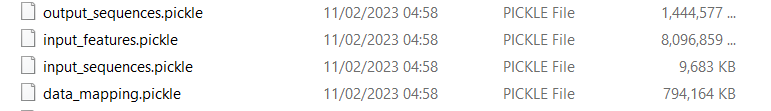

Now it is time to create our model for training.. go on with the second notebook